In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

## Optimizing YAG and Beam Source to Maximize the Fluorescence Signal
The QSwitch delay is set to 160 $\mu$s, corresponding to 35.8 mJ (as measured on 2020-11-2 19:50).  
The detection line is set to R0 F2 with 25 mW UV, with 2 passes.  
A resonant polarization switching EOM @ 1.56 MHz is used.  
Target location -5500,-5500 (x,y target coordinates, y,x mirror coordinates) was used for all measurements.  
Axis 1 of the mirror moves the ablation spot along y on the mirror, axis 2 along x, hence the flipped coordinate systems.  
Neon flow at 20 sccm.  
When below the lens focal length is scanned, `d` refers to the indicator on the horizontal translation stage.

In [2]:
fname = "2020_11_2.hdf"
dset_name = "1604366317 signal optimization"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [3]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [4]:
pmt_data = np.array([pxie[idx][:,pmt_channel] for idx in range(1, len(pxie)+1)])

11 : 60594.38 +/-  911.26
10 : 60527.72 +/- 1046.66
9  : 54985.60 +/- 1280.77
8  : 52227.86 +/- 1355.89
7  : 53303.64 +/-  886.07
6  : 47310.85 +/- 1045.53
5  : 43998.42 +/-  927.85
4  : 39704.16 +/-  940.07
3  : 32408.03 +/- 1197.67


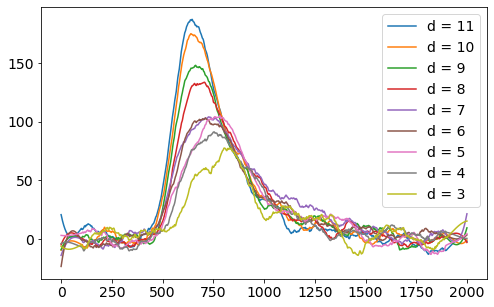

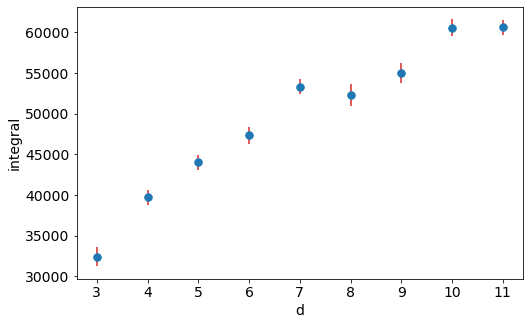

In [5]:
# took 10 shots per focal length
focus_scan_data = {f: [] for f in np.append(np.arange(11,3-1,-1), np.arange(4,11+1,1))}
for idx, f in enumerate(np.append(np.arange(11,3-1,-1), np.arange(4,11+1,1))):
    focus_scan_data[f].extend(pmt_data[idx*10:(idx+1)*10])
    
fig, ax = plt.subplots(figsize = (8,5))
for f,vals in focus_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 201,3), label = f'd = {f}')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for f, vals in focus_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(f, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    print(f'{f:<3}: {np.trapz(dat):.2f} +/- {std:>7.2f}')
    
ax.set_xlabel('d')
ax.set_ylabel('integral')
set_fontsize(ax, 14)

In [6]:
# removing the first indices used for the first focal length scan
pmt_data = pmt_data.reshape(-1,10,2000)[17:]

## Edmund Optics Research Grade Adjustable Beam Expander (2x -> 8x)
1064 AR coating  
changing the beam expander configuration  
lens is set to d = 11  
beam expaneder has a numeric and alpha numeric ring  
was set to 7 E, but from the data sheet it should have been set to 7 and 1/4 between D and E  
Tried several combinations of numeric and alpha numeric settings (here D 1/4 means 1/4 between D and E)

7 - D 1/4 :  3681.85 +/- 1227.91
7 - E     : 64357.71 +/- 1193.41
7 - E 1/2 : 67800.13 +/- 1180.71
7 - F     : 64032.40 +/- 1209.66


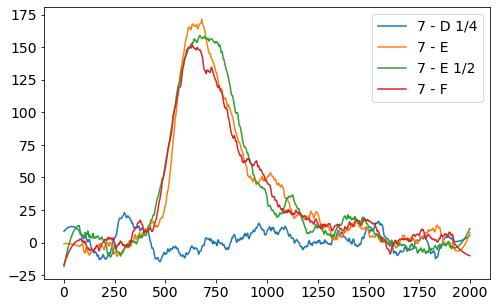

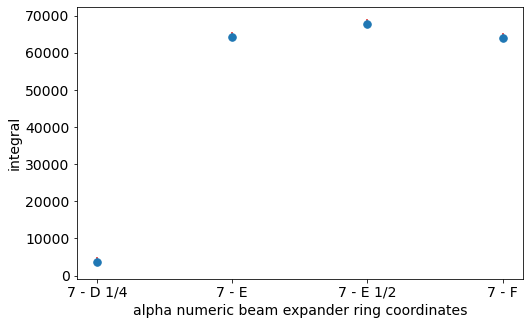

In [7]:
combinations = ((7, 'D 1/4'),
                (7, 'E'),
                (7, 'E 1/2'),
                (7, 'F'))

fig, ax = plt.subplots(figsize = (8,5))
for idx, c in enumerate(combinations):
    vals = pmt_data[idx]
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 151,2), label = f'{c[0]} - {c[1]}')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for idx, c in enumerate(combinations):
    vals = pmt_data[idx]
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(idx, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    print(f'{c[0]} - {c[1]:<6}: {np.trapz(dat):>8.2f} +/- {std:.2f}')

ax.set_xticks(list(range(len(combinations))))
ax.set_xticklabels([f'{c[0]} - {c[1]}' for c in combinations])
ax.set_ylabel('integral')
ax.set_xlabel('alpha numeric beam expander ring coordinates')
set_fontsize(ax, 14)

In [8]:
# removing previous data points
pmt_data = pmt_data[len(combinations):]

## Moving the lens again

The beam expander is now set to 7 and D 1/4, and now checking several values for the lens

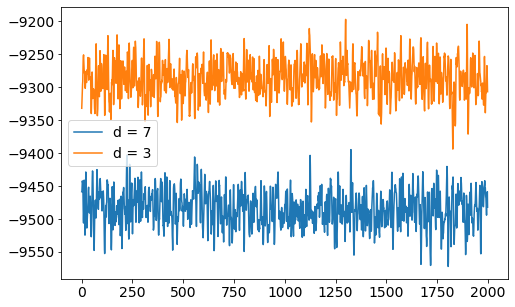

In [9]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.mean(pmt_data[0], axis = 0), label = 'd = 7')
ax.plot(np.mean(pmt_data[1], axis = 0), label = 'd = 3')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [10]:
pmt_data = pmt_data[2:]

## Varying Beam Expander Numeric Ring
Setting the lens to 11 and the beam expander to 7 E

7   : 68662.33 +/-  769.85
8   : 15606.69 +/- 1195.97
6   : 79819.01 +/- 1204.25
6.5 : 81498.45 +/-  968.77
5.5 : 71387.89 +/-  903.32
5   : 17777.53 +/-  878.58


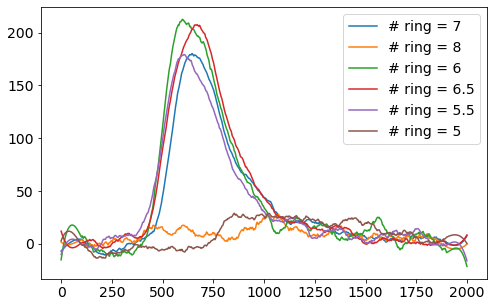

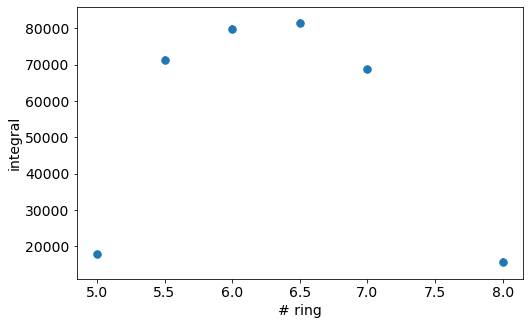

In [11]:
numeric = [7,8,6,6.5,7,7,6.5,6.5,5.5,5.5,5,5]
numeric_scan_data = {n: [] for n in numeric}

for idx, n in enumerate(numeric):
    numeric_scan_data[n].extend(pmt_data[idx])

fig, ax = plt.subplots(figsize = (8,5))
for n,vals in numeric_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 201,3), label = f'# ring = {n}')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for n, vals in numeric_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(n, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    print(f'{n:<4}: {np.trapz(dat):.2f} +/- {std:>7.2f}')
    
ax.set_xlabel('# ring')
ax.set_ylabel('integral')
set_fontsize(ax, 14)

In [12]:
pmt_data = pmt_data[len(numeric):]

## Scanning QSwitch Delay
setting the numeric ring to 6.5, now scanning Qswitch delay

150 :  84021.64 +/- 947.08
140 :  98365.91 +/- 658.14
130 : 102611.20 +/- 854.19
120 :  94048.93 +/- 954.21
115 :  97695.51 +/- 919.37
160 :  85618.83 +/- 921.17


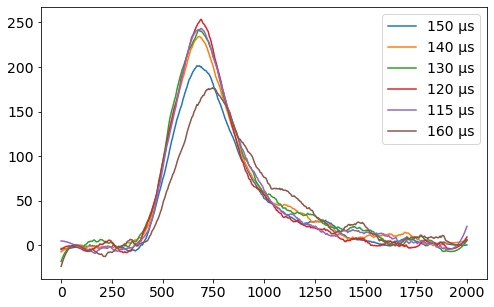

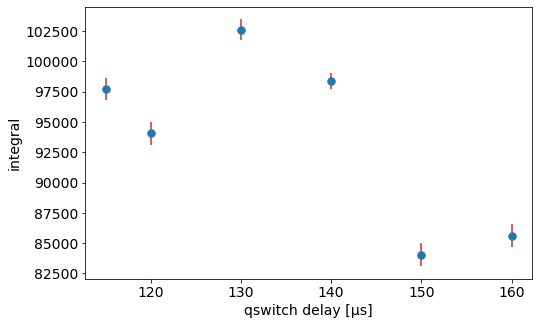

In [13]:
qswitch = [150,150,140,140,130,130,120,120,115,115,130,130,140,140,150,150,160,160]
qswitch_scan_data = {qs: [] for qs in qswitch}

for idx, qs in enumerate(qswitch):
    qswitch_scan_data[qs].extend(pmt_data[idx])

fig, ax = plt.subplots(figsize = (8,5))
for qs,vals in qswitch_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 201,3), label = f'{qs} μs')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for qs, vals in qswitch_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(qs, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    
    print(f'{qs:<4}: {np.trapz(dat):>9.2f} +/- {std:>6.2f}')
    
ax.set_xlabel('qswitch delay [μs]')
ax.set_ylabel('integral')
set_fontsize(ax, 14)

In [14]:
pmt_data = pmt_data[len(qswitch):]

setting the qswitch to 140 $\mu$s, now scanning the neon flow rate

## Scanning Neon Flow Rate

30  : 86716.96 +/-  951.90
35  : 84552.64 +/-  865.72
15  : 83536.05 +/-  863.20
25  : 97444.98 +/-  864.71
10  : 65584.92 +/- 1022.41
20  : 97368.25 +/-  926.98


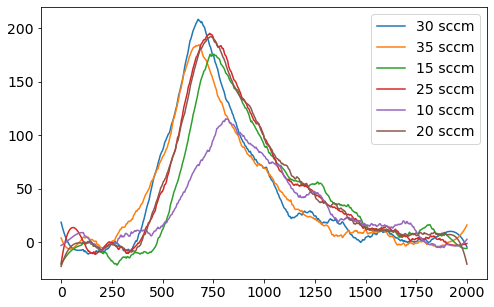

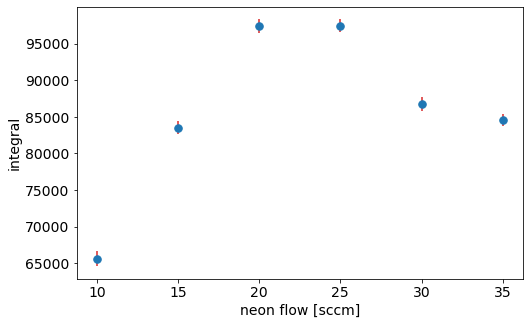

In [15]:
flowrate = [30,30,35,35,15,15,25,25,10,10,20,20]
flowrate_scan_data = {qs: [] for qs in flowrate}

for idx, qs in enumerate(flowrate):
    flowrate_scan_data[qs].extend(pmt_data[idx])

fig, ax = plt.subplots(figsize = (8,5))
for flr,vals in flowrate_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 201,3), label = f'{flr} sccm')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for flr, vals in flowrate_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(flr, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    print(f'{flr:<4}: {np.trapz(dat):.2f} +/- {std:>7.2f}')
    
ax.set_xlabel('neon flow [sccm]')
ax.set_ylabel('integral')
set_fontsize(ax, 14)

In [16]:
pmt_data = pmt_data[len(flowrate):]

## Change PMT Voltage
checking signal with PMT voltage at -900 V instead of -850 V

138169.42 +/- 1261.86


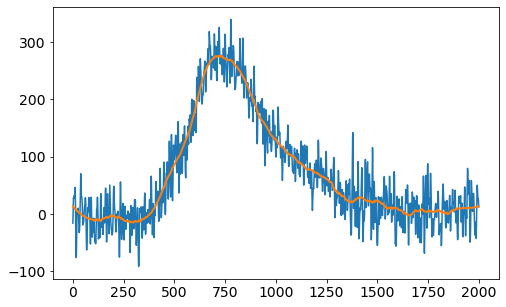

In [17]:
vals = pmt_data[:2].reshape(20,2000)
dat = -vals.mean(axis = 0)
dat -= np.append(dat[:250],dat[-100:]).mean()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(dat)
ax.plot(savgol_filter(dat, 201,3), lw = 2)
set_fontsize(ax, 14)

std = np.std(vals, axis = 0)
std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
print(f'{np.trapz(dat):.2f} +/- {std:.2f}')

SNR seems to be slightly better with larger PMT voltage. Had assumed majority of noise came from laser reflections and PMT voltage would scale signal and noise by same factor.

In [18]:
pmt_data = pmt_data[2:]

Moved the translation stage 1" forward, scanning the focal length again, now 1 is where 11 was.  
Beam expander is set to 6.5 E.  
QSwitch set to 160 $\mu$s.  
20 sccm  
-850 V PMT

1  : 83327.40 +/-  919.00
2  : 83685.43 +/-  891.69
3  : 75435.47 +/-  993.88
4  : 80856.15 +/- 1453.45
5  : 82365.67 +/- 1747.28
6  : 76775.01 +/- 1189.60
7  : 86744.85 +/- 1024.29
8  : 85481.62 +/- 1417.57
9  : 79202.97 +/- 1087.34
10 : 52285.02 +/- 1175.63


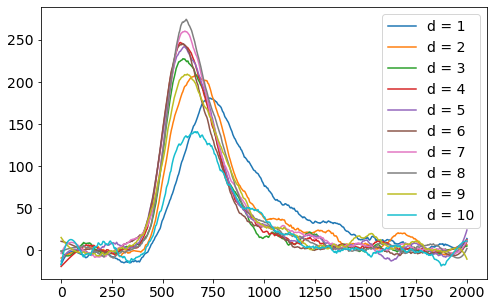

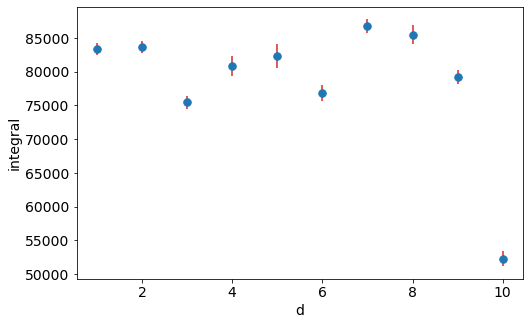

In [19]:
focal_scan = np.append(np.arange(1,11,1),np.arange(9,1-1,-1))
focal_scan_data = {fs: [] for fs in focal_scan}

for idx, qs in enumerate(focal_scan):
    focal_scan_data[qs].extend(pmt_data[idx])

fig, ax = plt.subplots(figsize = (8,5))
for fs,vals in focal_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 201,3), label = f'd = {fs}')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for fs, vals in focal_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(fs, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    print(f'{fs:<3}: {np.trapz(dat):.2f} +/- {std:>7.2f}')
    
ax.set_xlabel('d')
ax.set_ylabel('integral')
set_fontsize(ax, 14)

In [20]:
pmt_data = pmt_data[len(focal_scan):]

Checking the beam expander rings adjustment again, now with the lens focal length set to 7.

In [21]:
pmt_data = pmt_data.reshape(-1,20,2000)

7   - E: 36295.25 +/- 859.00
6.5 - E: 77383.70 +/- 975.98
5   - E: 81766.87 +/- 907.81


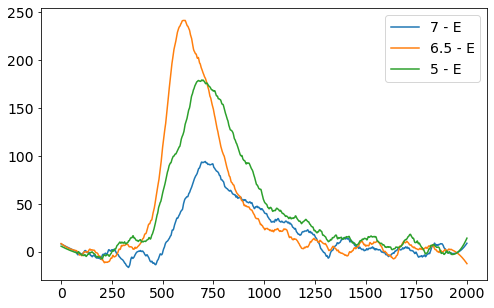

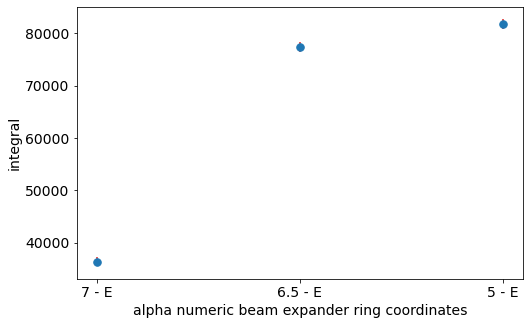

In [22]:
combinations = ((7, 'E'),
                (6.5, 'E'),
                (5, 'E'))

fig, ax = plt.subplots(figsize = (8,5))
for idx, c in enumerate(combinations):
    vals = pmt_data[idx]
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 151,2), label = f'{c[0]} - {c[1]}')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for idx, c in enumerate(combinations):
    vals = pmt_data[idx]
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(idx, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    print(f'{c[0]:<3} - {c[1]}: {np.trapz(dat):>8.2f} +/- {std:.2f}')

ax.set_xticks(list(range(len(combinations))))
ax.set_xticklabels([f'{c[0]} - {c[1]}' for c in combinations])
ax.set_ylabel('integral')
ax.set_xlabel('alpha numeric beam expander ring coordinates')
set_fontsize(ax, 14)

In [23]:
pmt_data = pmt_data[len(combinations):]

checking qswitch delay again briefly, with the beam expander set to 6.5 E

140 :  80346.56 +/- 859.59
120 :  86343.16 +/- 865.68
150 :  80172.94 +/- 945.21


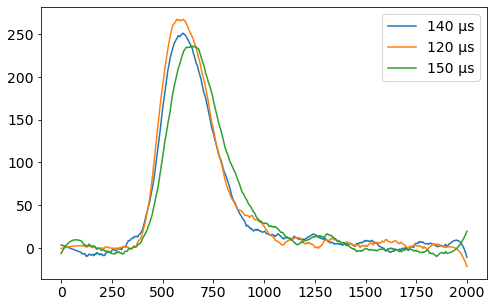

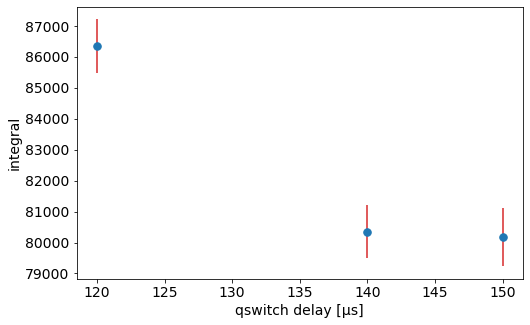

In [24]:
qswitch = [140,120,150]
qswitch_scan_data = {qs: [] for qs in qswitch}

for idx, qs in enumerate(qswitch):
    qswitch_scan_data[qs].extend(pmt_data[idx])

fig, ax = plt.subplots(figsize = (8,5))
for qs,vals in qswitch_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    ax.plot(savgol_filter(dat, 201,3), label = f'{qs} μs')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
for qs, vals in qswitch_scan_data.items():
    dat = -np.mean(vals, axis = 0)
    dat -= np.mean(np.append(dat[:250], dat[-250:]))
    std = np.std(vals, axis = 0)
    std = np.sqrt(np.sum((std/np.sqrt(len(vals)))**2))
    ax.errorbar(qs, np.trapz(dat), yerr = std, fmt = '.', ms = 15, color = 'C0', ecolor = 'C3')
    
    print(f'{qs:<4}: {np.trapz(dat):>9.2f} +/- {std:>6.2f}')
    
ax.set_xlabel('qswitch delay [μs]')
ax.set_ylabel('integral')
set_fontsize(ax, 14)